In [1]:
from IPython.core.debugger import set_trace

import numpy as np

import import_ipynb
from environment import *


importing Jupyter notebook from environment.ipynb
importing Jupyter notebook from config.ipynb


In [2]:
def heuristicLWR(num_jobs, num_mc, machines, durations):
    
    
    machines_ = np.array(machines)
    tmp = np.zeros((num_jobs,num_mc+1), dtype=int)
    tmp[:,:-1] = machines_
    machines_ = tmp
    
    
    durations_ = np.array(durations)
    tmp = np.zeros((num_jobs,num_mc+1), dtype=int)
    tmp[:,:-1] = durations_
    durations_ = tmp
    
    indices = np.zeros([num_jobs], dtype=int)
    
    # Internal variables
    previousTaskReadyTime = np.zeros([num_jobs], dtype=int)
    machineReadyTime = np.zeros([num_mc], dtype=int)

    placements = [[] for _ in range(num_mc)]
    

    # While...
    while(not np.array_equal(indices, np.ones([num_jobs], dtype=int)*num_mc)):
        
        machines_Idx = machines_[range(num_jobs),indices]
        durations_Idx = durations_[range(num_jobs),indices]

        
        # 1: Check previous Task and machine availability
        mask = np.zeros([num_jobs], dtype=bool)
        
        for j in range(num_jobs):
            
            if previousTaskReadyTime[j] == 0 and machineReadyTime[machines_Idx[j]] == 0 and indices[j]<num_mc:
                mask[j] = True


        
        # 2: Competition SPT
        
        for m in range(num_mc):
            
            job = None
            remaining = 99999
            
            for j in range(num_jobs):
                
                tmp = np.sum(durations_[j][indices[j]:])
                
                if machines_Idx[j] == m and tmp < remaining and mask[j]:
                    job = j
                    remaining = tmp
            
            
            if job != None:
                
                placements[m].append([job, indices[job]])

                previousTaskReadyTime[job] += durations_Idx[job]
                machineReadyTime[m] += durations_Idx[job]

                indices[job] += 1

                
                
        # time +1
        
        previousTaskReadyTime = np.maximum(previousTaskReadyTime - 1 , np.zeros([num_jobs], dtype=int)) 
        machineReadyTime = np.maximum(machineReadyTime - 1 , np.zeros([num_mc], dtype=int)) 
        
        
    return placements


Makespan:  41


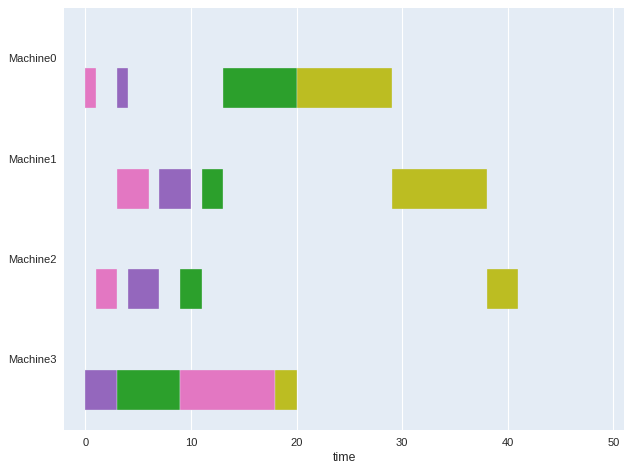

In [3]:
if __name__ == "__main__":
    
    
    # Import environment
    config = Config()
    config.machine_profile = "xsmall_default"
    config.job_profile = "xsmall_default"
    config.reconfigure()
    
    # Configure environment
    env = Environment(config)
    env.clear()
    
    
    # Read problem instance
    filename = "datasets/inference/dataset_xsmall.data"

    with open(filename, "r") as file:
        NB_JOBS, NB_MACHINES = [int(v) for v in file.readline().split()]
        JOBS = [[int(v) for v in file.readline().split()] for i in range(NB_JOBS)]

    #-----------------------------------------------------------------------------
    # Prepare the data for modeling
    #-----------------------------------------------------------------------------

    # Build list of machines. MACHINES[j][s] = id of the machine for the operation s of the job j
    machines = [[JOBS[j][2 * s] for s in range(NB_MACHINES)] for j in range(NB_JOBS)]


    # Build list of durations. DURATION[j][s] = duration of the operation s of the job j
    durations = [[JOBS[j][2 * s + 1] for s in range(NB_MACHINES)] for j in range(NB_JOBS)]


    placements = heuristicLWR(NB_JOBS, NB_MACHINES, machines, durations)
    

    env.step(machines, durations, placements)
    
    print("Makespan: ", env.makespan)
    
    env.plot(save=False)
    